In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule2

trans = {
	'HorizontalFlip': {'p': 0.5},
	'VerticalFlip': {'p': 0.5},
	'RandomRotate90': {'p': 0.5},
	'Transpose': {'p': 0.5},
}
dm = DataModule2(batch_size=4, train_trans=trans)
dm.setup()

train: 8689
test: 2773


In [3]:
x1, x2, labels = next(iter(dm.train_dataloader()))

x1.shape, x2.shape

(torch.Size([4, 12, 256, 256, 3]), torch.Size([4, 12, 256, 256, 3]))

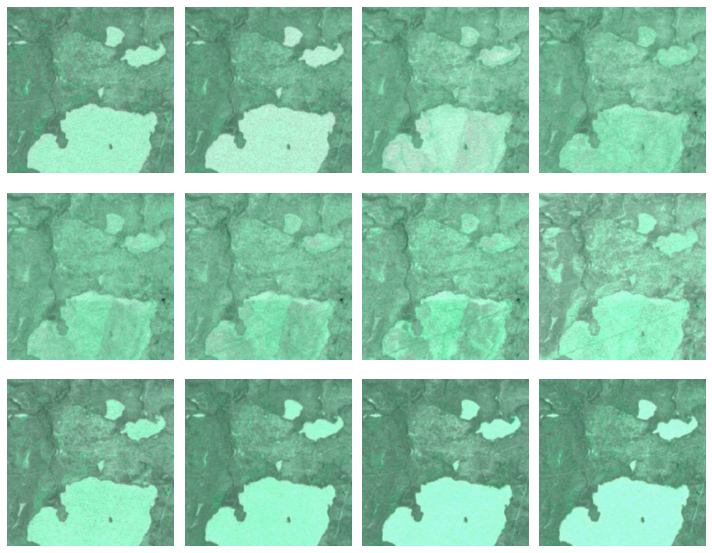

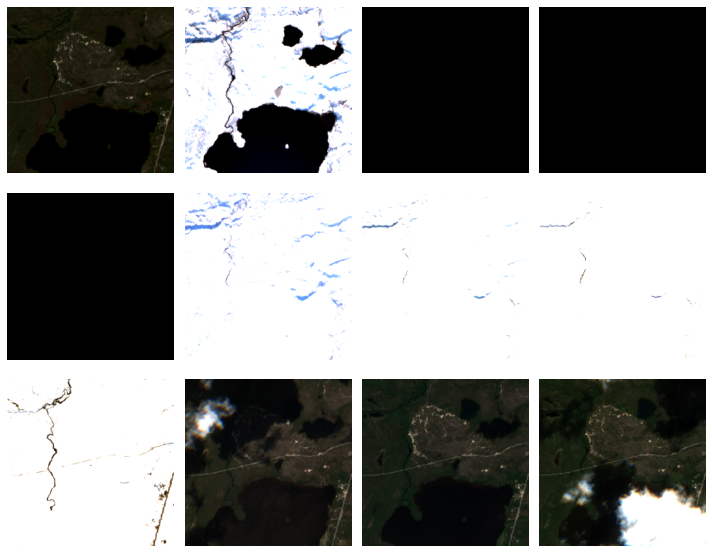

In [4]:
import matplotlib.pyplot as plt 

dl = dm.train_dataloader(shuffle=False)
x1, x2, labels = next(iter(dl))

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x1[0][i*4+j])
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x2[0][i*4+j])
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

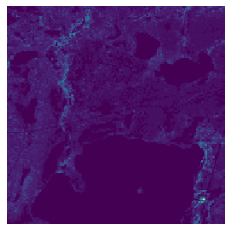

In [5]:
plt.imshow(labels[0])
plt.axis('off')
plt.show()

In [6]:
from src.models.unet_df import UNetDF2

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 3,
    'in_channels_s2': 3,
    'seq_len': 12,
}

model = UNetDF2(hparams)

outputs = model(x1, x2)

outputs.shape

torch.Size([4, 256, 256])

In [7]:
import pytorch_lightning as pl

dm = DataModule2(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',    
    'in_channels_s1': 3,
    'in_channels_s2': 3,
    'seq_len': 12,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetDF2(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=300,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 48.5 M
3 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
70.9 M    Trainable params
0         Non-trainable params
70.9 M    Total params
141.732   Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers 

Training: 0it [00:00, ?it/s]

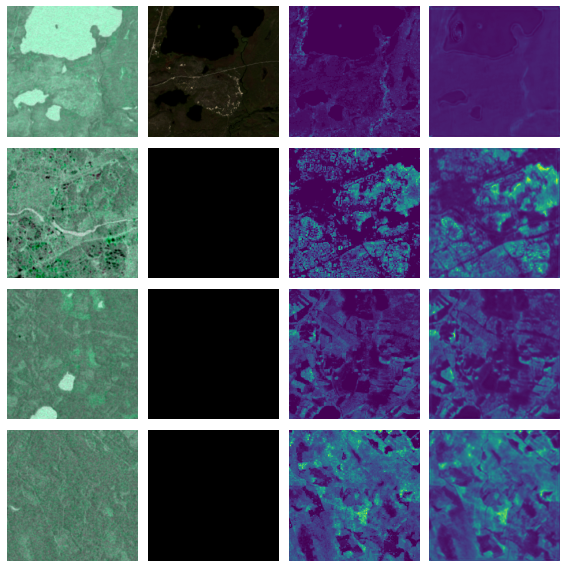

In [8]:
import matplotlib.pyplot as plt 

x1, x2, labels = next(iter(dm.train_dataloader(shuffle=False)))
preds = module.predict(x1, x2)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(x1[i][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(x2[i][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()